# Importing Libs

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings as w
w.filterwarnings('ignore')

In [2]:
df=pd.read_csv('/kaggle/input/sales-forecasting/train.csv')

In [3]:
df['Order Date']=pd.to_datetime(df['Order Date'],format='%d/%m/%Y')
df['Ship Date']=pd.to_datetime(df['Ship Date'],format='%d/%m/%Y')
df['Processing Time']=(df['Ship Date']-df['Order Date']).dt.days

In [4]:
df['Postal Code'] = df['Postal Code'].fillna(5401)

# EDA

## Customer Segment Distribution

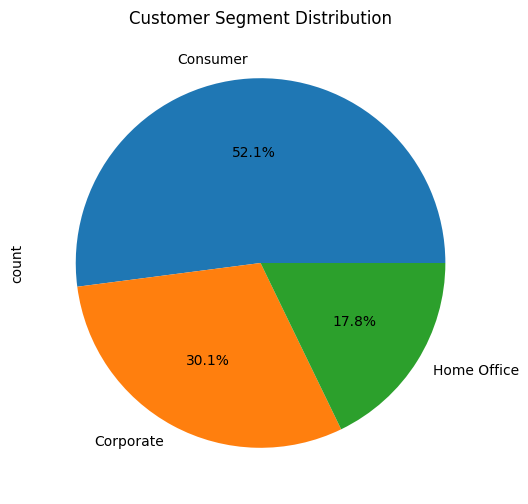

In [5]:
df['Segment'].value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(6,6))
plt.title("Customer Segment Distribution")
plt.show()

## Monthly Sales Trend

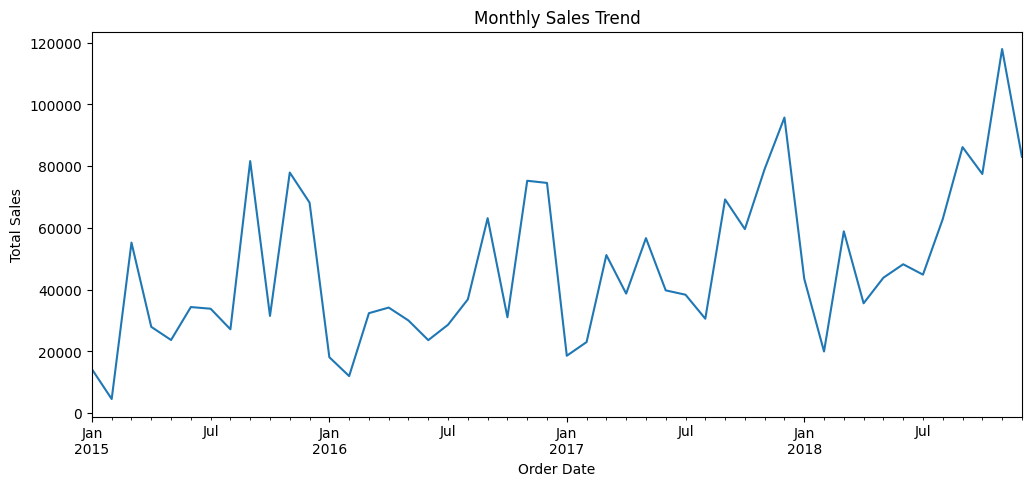

In [6]:
df.set_index('Order Date')['Sales'].resample('M').sum().plot(figsize=(12,5))
plt.title("Monthly Sales Trend")
plt.ylabel("Total Sales")
plt.show()

## Total Sales by Region

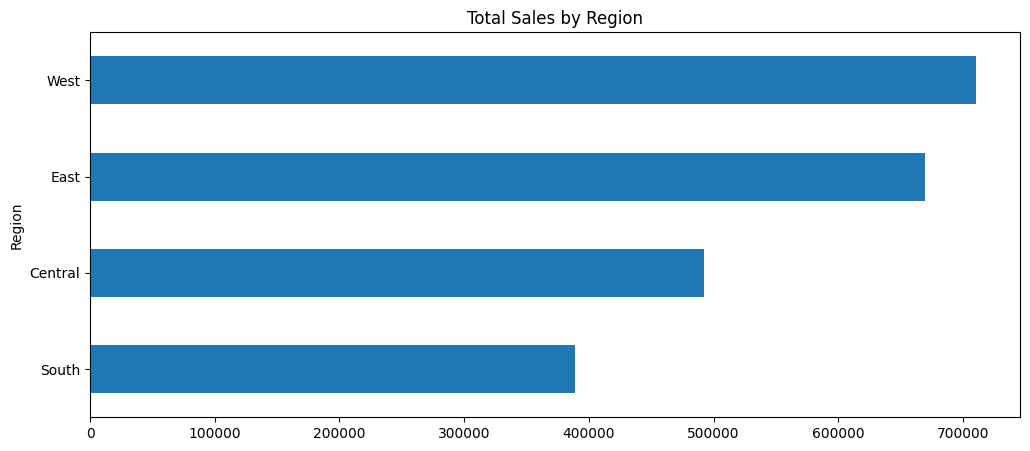

In [7]:
plt.figure(figsize=(12,5))
df.groupby('Region')['Sales'].sum().sort_values().plot(kind='barh')
plt.title("Total Sales by Region")
plt.show()

## Time Taken by different Ship modes

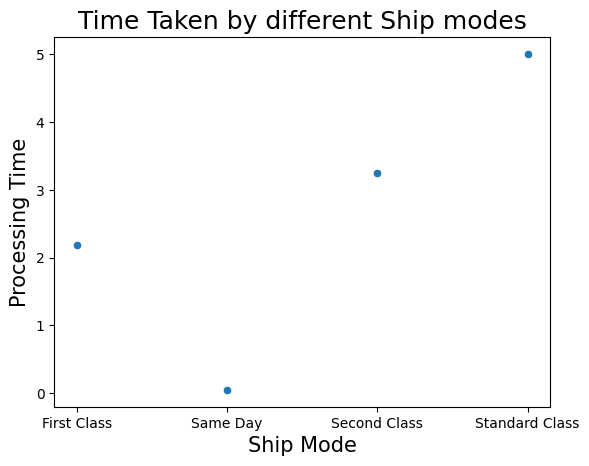

In [8]:
mean_delivery_time=df.groupby(['Ship Mode'])['Processing Time'].mean().reset_index()
sns.scatterplot(x='Ship Mode',y='Processing Time',data=mean_delivery_time)
plt.xlabel("Ship Mode",fontsize=15)
plt.ylabel("Processing Time",fontsize=15)
plt.title("Time Taken by different Ship modes", fontsize=18)
plt.show()

## Most Valuable Customers

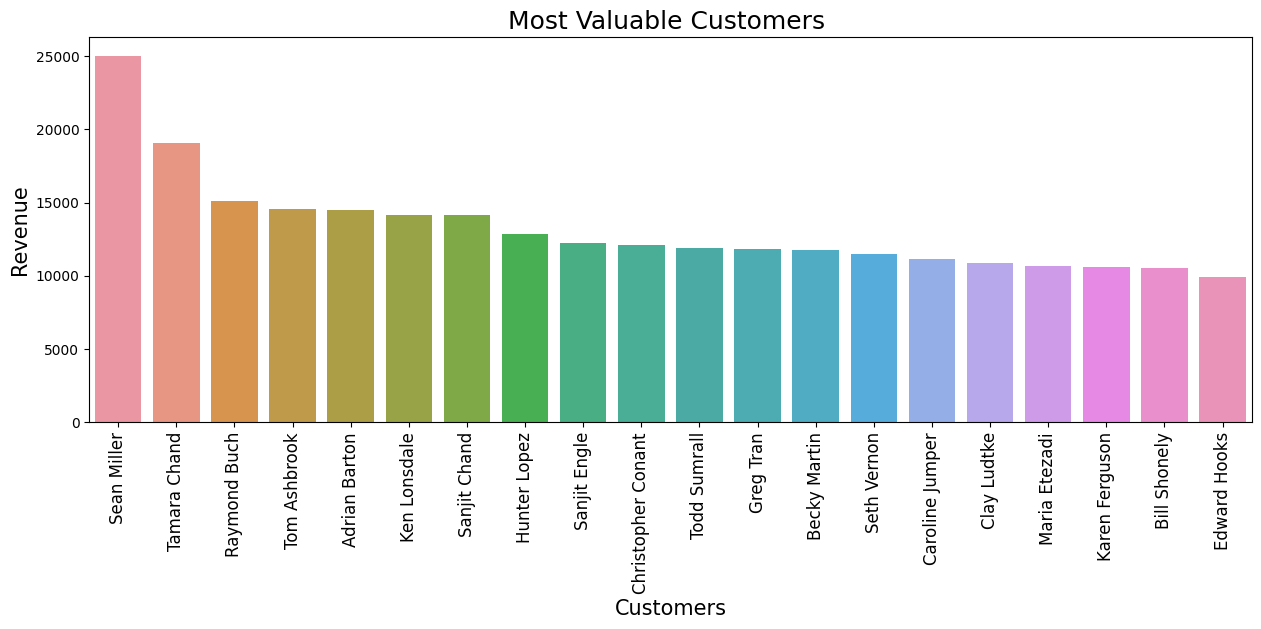

In [9]:
df_no_date = df.drop(columns=df.select_dtypes(include='datetime').columns)
top_costomer=df_no_date.groupby(['Customer Name']).sum().sort_values(('Sales'),ascending=False).head(20)
top_costomer=top_costomer.reset_index()
plt.figure(figsize = (15,5))
sns.barplot(x='Customer Name',y='Sales',data=top_costomer)
plt.xlabel("Customers",fontsize=15)
plt.ylabel("Revenue",fontsize=15)
plt.xticks(fontsize=12, rotation=90)
plt.title("Most Valuable Customers ", fontsize=18)
plt.show()

## Sub-Categories Distribution per Category

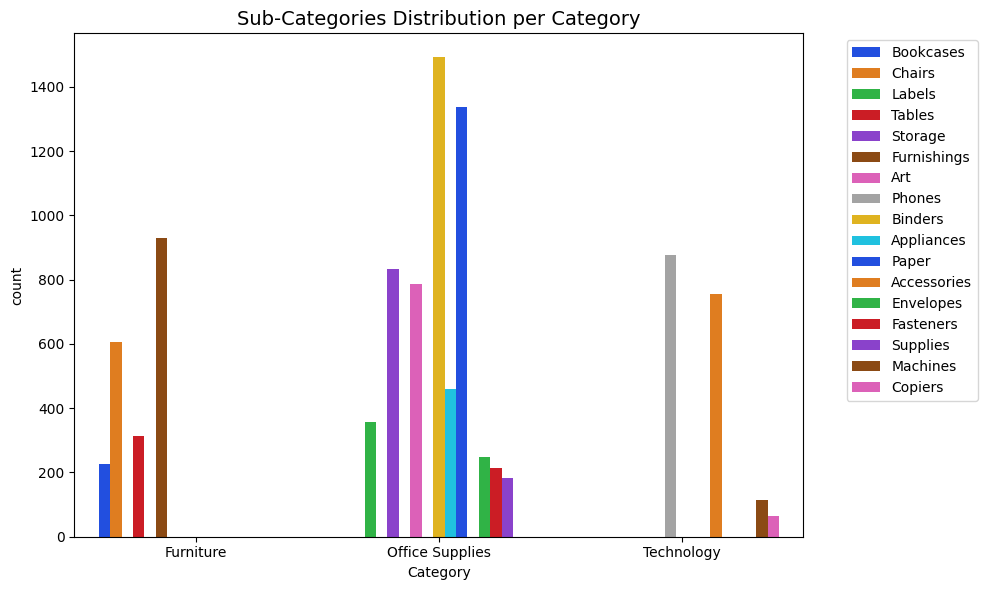

In [10]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Category', hue='Sub-Category', palette='bright')
plt.title("Sub-Categories Distribution per Category", fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Total Sales by Region

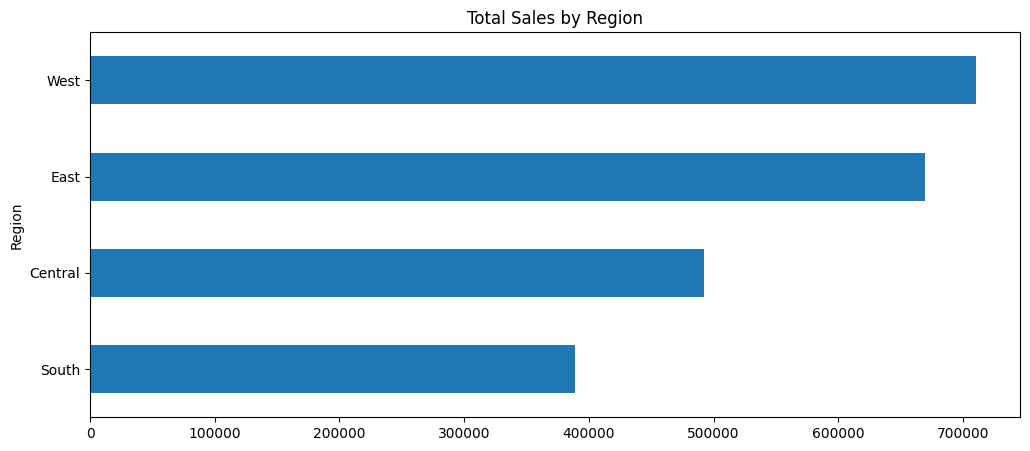

In [11]:
plt.figure(figsize=(12,5))
df.groupby('Region')['Sales'].sum().sort_values().plot(kind='barh')
plt.title("Total Sales by Region")
plt.show()

## Top 10 Cities by Sales

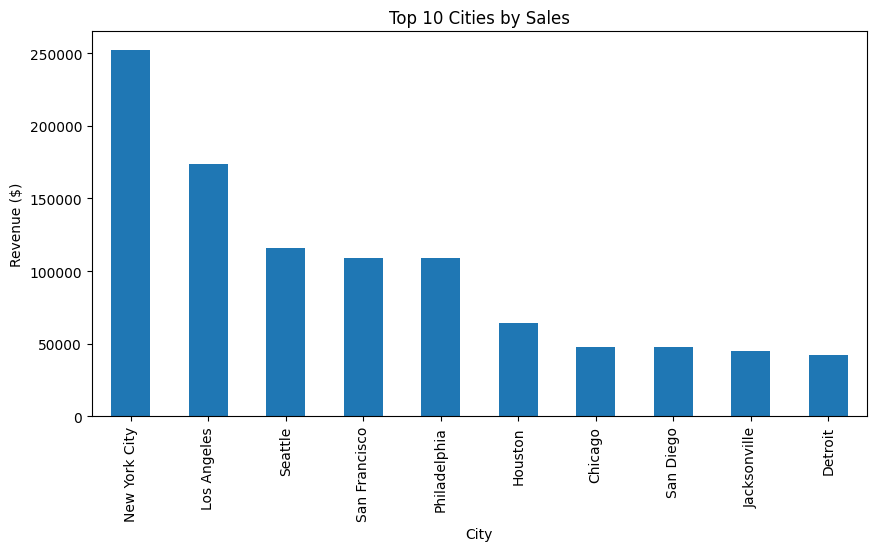

In [12]:
top_cities = df.groupby('City')['Sales'].sum().sort_values(ascending=False).head(10)
top_cities.plot(kind='bar', figsize=(10,5))
plt.title("Top 10 Cities by Sales")
plt.ylabel("Revenue ($)")
plt.xticks(rotation=90)
plt.show()

## Corr Matrix

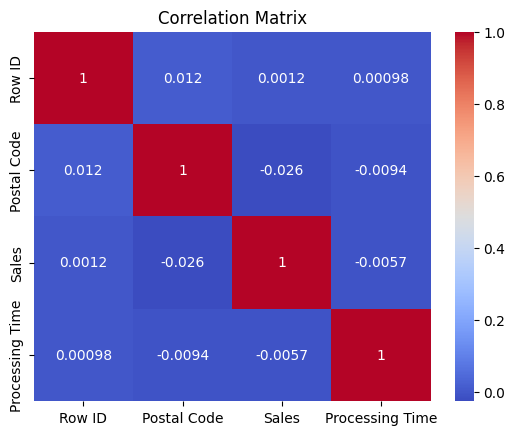

In [13]:
numeric_df = df.select_dtypes(include=['int64','float64'])
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

# Model

## Outliers removal

In [14]:
q1 = df['Sales'].quantile(0.01)
q99 = df['Sales'].quantile(0.99)
df = df[(df['Sales'] >= q1) & (df['Sales'] <= q99)]


## Model Linear Reg

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
x=df.drop(columns=['Row ID','Order ID','Customer ID','Product ID','Sales'],axis=1)
y=df['Sales']

num_cols=x.select_dtypes(include=['number']).columns.tolist()
cat_cols=x.select_dtypes(include=['object']).columns.tolist()

x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=42,test_size=0.2)

preprocessing=ColumnTransformer([('scaler',StandardScaler(),num_cols),
                                ('encoder',OneHotEncoder(drop='first',handle_unknown='ignore'),cat_cols)])

model=Pipeline([('pre',preprocessing),
               ('lr',LinearRegression())])

model.fit(x_train,y_train)
pred=model.predict(x_test)

r2 = r2_score(y_test, pred)
mae = mean_absolute_error(y_test, pred)
mse = mean_squared_error(y_test, pred)

print(r2*100)
print(mae)
print(mse)

47.23270614591753
143.61363784330564
52333.97397231166


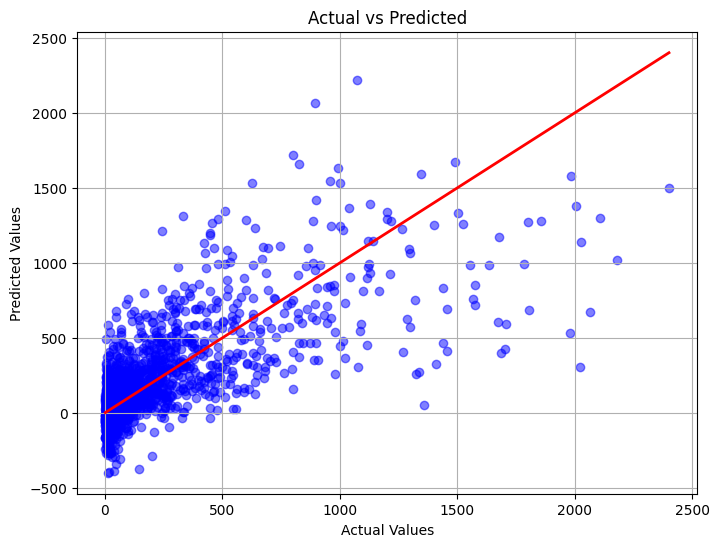

In [16]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, pred, color='blue', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='-', linewidth=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted')
plt.grid(True)
plt.show()